## Python для RFM-кластеризации и решения других аналитических задач

### Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).

2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.

3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3).

5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.

6. Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникального идентификатора курса.

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
assessments = pd.read_csv('assessments.csv')

In [4]:
courses = pd.read_csv('courses.csv')

In [5]:
studentAssessment = pd.read_csv('studentAssessment.csv')

In [6]:
studentRegistration = pd.read_csv('studentRegistration.csv')

### Исследуем данные

#### 1. assessments

— этот файл содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).

- code_module — идентификационный код предмета.

- code_presentation — семестр (Идентификационный код).

- id_assessment — тест (Идентификационный номер ассессмента).

- assessment_type — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

- date — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

- weight — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [7]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [8]:
assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [9]:
assessments.nunique()

code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64

In [20]:
assessments.describe()

,id_assessment,date,weight
count,206.000000,195.000000,206.000000
mean,26473.975728,145.005128,20.873786
std,10098.625521,76.001119,30.384224
min,1752.000000,12.000000,0.000000
25%,15023.250000,71.000000,0.000000
50%,25364.500000,152.000000,12.500000
75%,34891.750000,222.000000,24.250000
max,40088.000000,261.000000,100.000000


null-значения есть только в столбце date по нескольким из экзаменов. По каким причинам дата отсутствует непонятно. Удалять эти значения не будем, дабы не потерять ценные данные по сдаче экзаменов.

In [32]:
assessments.query("date == 'NaN'") 

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


#### 2. courses

— файл содержит список предметов по семестрам.

- code_module — предмет (идентификационный код).

- code_presentation — семестр (идентификационный код).

- module_presentation_length — продолжительность семестра в днях.

In [39]:
courses

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [36]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [37]:
courses.nunique()

code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64

#### 3. studentAssessment

— этот файл содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

- id_assessment — тест (идентификационный номер).

- id_student — идентификационный номер студента.

- date_submitted — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

- is_banked — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

- score — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [42]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [43]:
studentAssessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


null-значения есть только в столбце score. Непонятно, что это значит: тест пройден, но утеряна оценка, или тест все-таки не пройден. 

In [8]:
studentAssessment.query("score == 'NaN'") 

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


In [46]:
studentAssessment.nunique()

id_assessment       188
id_student        23369
date_submitted      312
is_banked             2
score               101
dtype: int64

In [45]:
studentAssessment.describe()

,id_assessment,id_student,date_submitted,is_banked,score
count,173912.000000,1.739120e+05,173912.000000,173912.000000,173739.000000
mean,26553.803556,7.051507e+05,116.032942,0.010977,75.799573
std,8829.784254,5.523952e+05,71.484148,0.104194,18.798107
min,1752.000000,6.516000e+03,-11.000000,0.000000,0.000000
25%,15022.000000,5.044290e+05,51.000000,0.000000,65.000000
50%,25359.000000,5.852080e+05,116.000000,0.000000,80.000000
75%,34883.000000,6.344980e+05,173.000000,0.000000,90.000000
max,37443.000000,2.698588e+06,608.000000,1.000000,100.000000


Отрицательные значения date_submitted означают сдачу теста до начала семестра.
Большая часть из них соответствует перезачетам тестов прошлых семестров (см. таблицу ниже, is_banked=1). 
Но что значит отрицательное значение, если это не перезачет?
Пока оставляем как есть.

In [13]:
studentAssessment.query('date_submitted < 0')\
                .groupby('is_banked')\
                .agg({'id_student':'count'})\
                .rename(columns={'id_student':'count_student'}) 

,count_student
is_banked,
0,148
1,1909


#### 4. studentRegistration

— этот файл содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре.

- code_module — предмет (идентификационный код).

- code_presentation — семестр (идентификационный код)

- id_student — идентификационный номер студента.

- date_registration — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

- date_unregistration — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [7]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [8]:
studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


Есть null-значения по столбцу date_registration. Непонятна причина, возможно данные о дате утеряны. Но так как по данным строкам есть date_unregistration, то не удаляем.

In [25]:
studentRegistration.query("date_registration == 'NaN'").head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
2344,BBB,2013B,630346,NaN,NaN
2538,BBB,2013J,57369,NaN,-1.0
2759,BBB,2013J,342678,NaN,-33.0
5356,BBB,2014B,582496,NaN,-126.0
5490,BBB,2014B,607646,NaN,-38.0


In [9]:
studentRegistration.describe()

,id_student,date_registration,date_unregistration
count,3.259300e+04,32548.000000,10072.000000
mean,7.066877e+05,-69.411300,49.757645
std,5.491673e+05,49.260522,82.460890
min,3.733000e+03,-322.000000,-365.000000
25%,5.085730e+05,-100.000000,-2.000000
50%,5.903100e+05,-57.000000,27.000000
75%,6.444530e+05,-29.000000,109.000000
max,2.716795e+06,167.000000,444.000000


In [10]:
studentRegistration.nunique()

code_module                7
code_presentation          4
id_student             28785
date_registration        332
date_unregistration      416
dtype: int64

### Сформулируем, что должно считаться курсом

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться курсом. Обосновать свой выбор ты можешь с помощью фактов сдачи экзаменов, распределения студентов и уникального идентификатора курса.

Сначала посмотрим на таблицу courses со списком курсов. Из нее непонятно, что именно является курсом: курс - это все модули и все семестры вместе взятые, или это один модуль включая все семестры по нему, или это один модуль и один семестр по нему ?

In [43]:
courses.head()

,code_module,code_presentation,module_presentation_length,code_course
0,AAA,2013J,268,AAA_2013J
1,AAA,2014J,269,AAA_2014J
2,BBB,2013J,268,BBB_2013J
3,BBB,2014J,262,BBB_2014J
4,BBB,2013B,240,BBB_2013B


Теперь посмотрим на таблицу studentRegistration:

In [61]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


Затем сгруппируем данные по id_student, чтобы рассчитать количество регистраций у каждого студента.
Отсортируем по убыванию. Видим, что максимальное количество регистраций - 5.

In [7]:
registrations_per_student = studentRegistration.groupby(['id_student'], as_index = False)\
                    .agg({'date_registration':'count'})\
                    .rename(columns = {'date_registration':'registrations_per_student'})\
                    .sort_values('registrations_per_student', ascending = False)
                    
registrations_per_student.head()

,id_student,registrations_per_student
13484,584077,5
12056,572154,4
1285,172965,4
11490,565275,4
9176,542562,4


Теперь посмотрим в процентном соотношении распредение студентов в зависимости от того, сколько регистраций они сделали:

In [8]:
(registrations_per_student.registrations_per_student.value_counts(normalize = True) * 100).round()

1    88.0
2    11.0
3     1.0
0     0.0
4     0.0
5     0.0
Name: registrations_per_student, dtype: float64

Построим график распредения студентов в зависимости от того, сколько регистраций они сделали.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


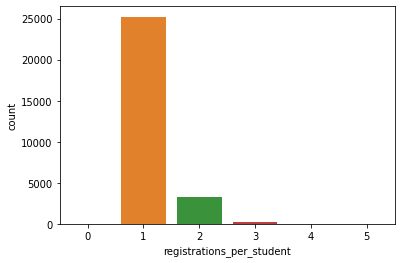

In [9]:
sns.countplot(registrations_per_student.registrations_per_student)

Видим, что у 88% студентов только одна регистрация. Каждой регистрации соответствует только один код модуля и один код семестра.

Значит, <b>курсом можно считать пару: один модуль и один семестр по нему</b>.
    
Визуально список курсов можно представить так, всего 22 курса:

In [36]:
courses['code_course'] = courses.code_module + '_' + courses.code_presentation
courses.code_course

0     AAA_2013J
1     AAA_2014J
2     BBB_2013J
3     BBB_2014J
4     BBB_2013B
5     BBB_2014B
6     CCC_2014J
7     CCC_2014B
8     DDD_2013J
9     DDD_2014J
10    DDD_2013B
11    DDD_2014B
12    EEE_2013J
13    EEE_2014J
14    EEE_2014B
15    FFF_2013J
16    FFF_2014J
17    FFF_2013B
18    FFF_2014B
19    GGG_2013J
20    GGG_2014J
21    GGG_2014B
Name: code_course, dtype: object

Подтвердим эту гипотезу, глядя на таблицу ассесментов. Видим, что по каждой паре модуль-семестр есть итоговый экзамен (по двум из них даже 2). Это логично, что в конце каждого курса должен быть экзамен.

In [34]:
assessments.query("assessment_type == 'Exam'")\
            .groupby(['code_module', 'code_presentation'], as_index = False)\
            .agg({'id_assessment':'count'})

,code_module,code_presentation,id_assessment
0,AAA,2013J,1
1,AAA,2014J,1
2,BBB,2013B,1
3,BBB,2013J,1
4,BBB,2014B,1
5,BBB,2014J,1
6,CCC,2014B,2
7,CCC,2014J,2
8,DDD,2013B,1
9,DDD,2013J,1


Кроме этого, по каждому курсу сумма весов остальных тестов составляет ровно 100% (кроме модуля GGG, по которому, по-видимому, учитывается только итоговый экзамен)

In [42]:
assessments.query("assessment_type != 'Exam'")\
            .groupby(['code_module', 'code_presentation'], as_index = False)\
            .agg({'weight':'sum'})

,code_module,code_presentation,weight
0,AAA,2013J,100.0
1,AAA,2014J,100.0
2,BBB,2013B,100.0
3,BBB,2013J,100.0
4,BBB,2014B,100.0
5,BBB,2014J,100.0
6,CCC,2014B,100.0
7,CCC,2014J,100.0
8,DDD,2013B,100.0
9,DDD,2013J,100.0


#### Cделаем еще одну проверку: 

Возьмем студентов с 1 регистрацией, которой соответствует 1 пара предмет-семестр в таблице регистраций. 

Для этих студентов количество уникальных пар предмет-семестр в таблице с данными о прохождении курсов тоже = 1. 

Значит у них был доступ к прохождению ровно того предмета и семестра, на который они регистрировались (а не на последующие семестры по данному предмету).

Это также подтверждает, что курсом можно считать пару предмет-семестр.

P.S. Таким образом можно перебрать и проверить все варианты (от 1 до 5).

In [73]:
registrations_per_student = studentRegistration.groupby(['id_student'], as_index = False)\
                    .agg({'code_module':'count'})\
                    .rename(columns = {'code_module':'registrations_per_student'})\
                    .sort_values('registrations_per_student', ascending = False)

registrations = registrations_per_student.query("registrations_per_student == 1").id_student

registrations.head()

19974    630696
19902    630264
15874    600816
15865    600766
19903    630269
Name: id_student, dtype: int64

In [72]:
code_courses = df.query("id_student in @registrations").groupby('id_student', as_index = False).code_course.nunique()

code_courses.code_course.unique()

array([1])

### Таким образом, мы убедились, что курсом можно считать пару модуль-семестр вида:


In [51]:
courses.code_course.head()

0    AAA_2013J
1    AAA_2014J
2    BBB_2013J
3    BBB_2014J
4    BBB_2013B
Name: code_course, dtype: object

### Объединим все таблицы в одну
При присоединении таблицы с регистрациями сделаем тип 'outer', чтобы не потерять студентов, которые зарегистрировались, но не сдавали тесты.

In [7]:
df = studentAssessment.merge(assessments, on = 'id_assessment', how = 'left')\
                    .merge(courses, on = ['code_module', 'code_presentation'], how = 'left')\
                    .merge(studentRegistration, on = ['code_module', 'code_presentation', 'id_student'], how ='outer')

df['code_course'] = df.code_module + '_' + df.code_presentation
df

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length,date_registration,date_unregistration,code_course
0,1752.0,11391,18.0,0.0,78.0,AAA,2013J,TMA,19.0,10.0,268.0,-159.0,NaN,AAA_2013J
1,1753.0,11391,53.0,0.0,85.0,AAA,2013J,TMA,54.0,20.0,268.0,-159.0,NaN,AAA_2013J
2,1754.0,11391,115.0,0.0,80.0,AAA,2013J,TMA,117.0,20.0,268.0,-159.0,NaN,AAA_2013J
3,1755.0,11391,164.0,0.0,85.0,AAA,2013J,TMA,166.0,20.0,268.0,-159.0,NaN,AAA_2013J
4,1756.0,11391,212.0,0.0,82.0,AAA,2013J,TMA,215.0,30.0,268.0,-159.0,NaN,AAA_2013J
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180657,NaN,2282141,NaN,NaN,NaN,GGG,2014J,NaN,NaN,NaN,NaN,-32.0,62.0,GGG_2014J
180658,NaN,2338614,NaN,NaN,NaN,GGG,2014J,NaN,NaN,NaN,NaN,-23.0,58.0,GGG_2014J
180659,NaN,2475886,NaN,NaN,NaN,GGG,2014J,NaN,NaN,NaN,NaN,-31.0,NaN,GGG_2014J
180660,NaN,2608143,NaN,NaN,NaN,GGG,2014J,NaN,NaN,NaN,NaN,-45.0,48.0,GGG_2014J


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180662 entries, 0 to 180661
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id_assessment               173912 non-null  float64
 1   id_student                  180662 non-null  int64  
 2   date_submitted              173912 non-null  float64
 3   is_banked                   173912 non-null  float64
 4   score                       173739 non-null  float64
 5   code_module                 180662 non-null  object 
 6   code_presentation           180662 non-null  object 
 7   assessment_type             173912 non-null  object 
 8   date                        171047 non-null  float64
 9   weight                      173912 non-null  float64
 10  module_presentation_length  173912 non-null  float64
 11  date_registration           180614 non-null  float64
 12  date_unregistration         18454 non-null   float64
 13  code_course   

### Задача 1. Сколько студентов успешно сдали только один курс? 
(Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

Сначала отберем данные по следующим параметрам: 
тип теста - экзамен, кол-во баллов больше 40 (критерий успешной сдачи).

Затем сгруппируем по id_student и посчитаем кол-во курсов на каждого студента.

In [80]:
exam_success = df.query("assessment_type == 'Exam' and score >=40")\
    .groupby('id_student', as_index = False)\
    .agg({'code_course':'count'})\
    .rename(columns = {'code_course':'exam_success'})\
    .sort_values('exam_success', ascending = False)

exam_success

,id_student,exam_success
2048,592093,2
755,445917,2
1303,543788,2
1881,582879,2
769,447644,2
...,...,...
1398,551814,1
1399,552003,1
1400,552114,1
1401,552166,1


Посчитаем, сколько студентов успешно сдали только 1 курс:

In [83]:
exam_success.query('exam_success == 1').id_student.count()

3802

#### Ответ: 
3802 студента успешно сдали только 1 курс.

### Задача 2. Выяви самый сложный и самый простой экзамен: 
найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (10 баллов)

Отфильтруем данные по колонке assessment_type - возьмем только экзамены.

In [103]:
df_exam_only = df.query("assessment_type == 'Exam'")

Построим график - отразим средние оценки за экзамен по каждому курсу.

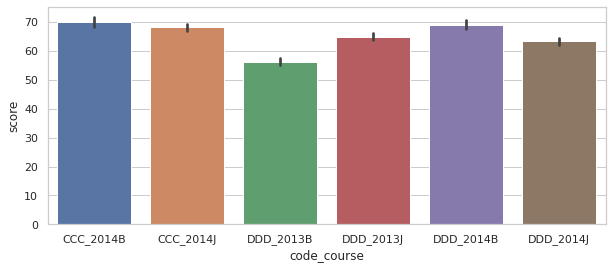

In [114]:
sns.barplot(data = df_exam_only, x = 'code_course', y = 'score')
sns.set(rc={'figure.figsize':(10,4)}, style="whitegrid")

Кроме этого также сделаем табличный расчет средних оценок по каждому курсу и экзамену*.

*в изначальных данных есть оценки только по экзаменам по 6 курсам (по остальным курсам нет данных о сдаче экзаменов)

In [119]:
df_exam_only.groupby(['code_course','id_assessment'], as_index = False)\
            .agg({'score':'mean'})\
            .sort_values('score', ascending = False)\
            .reset_index(drop = True)\
            .round(1)

,code_course,id_assessment,score
0,CCC_2014B,24290.0,70.0
1,DDD_2014B,25361.0,69.1
2,CCC_2014J,24299.0,68.2
3,DDD_2013J,25354.0,65.0
4,DDD_2014J,25368.0,63.3
5,DDD_2013B,25340.0,56.4


#### Ответ:

Самая высокая средняя оценка = 70.0 по курсу CCC_2014B, номер экзамена 24290

Самая низкая средняя оценка = 56.4 по курсу DDD_2013B, номер экзамена 25340

### Задача 3. По каждому предмету определи средний срок сдачи экзаменов 
(под сдачей понимаем последнее успешное прохождение экзамена студентом). (7 баллов) 

Проверка того, что каждый студент сдавал экзамен по курсу только 1 раз:

In [131]:
df.query("assessment_type == 'Exam'")\
    .groupby(['code_course', 'id_student'], as_index = False)\
    .agg({'id_assessment':'count'})\
    .sort_values('id_assessment')

,code_course,id_student,id_assessment
0,CCC_2014B,29764,1
3309,DDD_2013J,604317,1
3308,DDD_2013J,604281,1
3307,DDD_2013J,604156,1
3306,DDD_2013J,604072,1
...,...,...,...
1649,CCC_2014J,679886,1
1648,CCC_2014J,679750,1
1647,CCC_2014J,679733,1
1654,CCC_2014J,680133,1


По каждому предмету определим средний срок сдачи экзаменов:

In [141]:
exam_submitted = df.query("assessment_type == 'Exam' and score >=40")\
                    .groupby('code_module', as_index = False)\
                    .agg({'date_submitted':'mean'})\
                    .sort_values('date_submitted')\
                    .round()

exam_submitted

,code_module,date_submitted
1,DDD,238.0
0,CCC,239.0


#### Ответ:

Средний срок сдачи экзамена по предмету DDD - 238 дней, по предмету CCC - 239 дней.
По остальным экзаменам нет исходных данных.

### Задача 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)

#### 1.ТОП-3 по количеству регистраций :

In [28]:
count_registration = studentRegistration.groupby('code_module', as_index = False)\
                    .agg({'id_student':'count'})\
                    .rename(columns={'id_student':'count_registration'})\
                    .sort_values('count_registration', ascending = False)\
                    .reset_index(drop = True)
count_registration.head(3)

,code_module,count_registration
0,BBB,7909
1,FFF,7762
2,DDD,6272


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


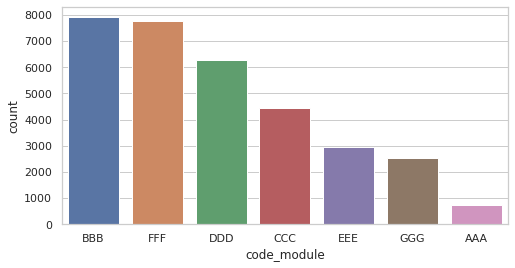

In [81]:
reg = studentRegistration.code_module 

sns.countplot(reg, order = reg.value_counts().index)

sns.set(rc={'figure.figsize':(8,4)}, style="whitegrid")

#### 2.ТОП-3 по количеству отмен регистраций :

In [78]:
count_unregistration = studentRegistration.groupby('code_module', as_index = False)\
                    .agg({'date_unregistration':'count'})\
                    .rename(columns={'date_unregistration':'count_unregistration'})\
                    .sort_values('count_unregistration', ascending = False)\
                    .reset_index(drop = True)
count_unregistration.head(3)

,code_module,count_unregistration
0,FFF,2380
1,BBB,2377
2,DDD,2235


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


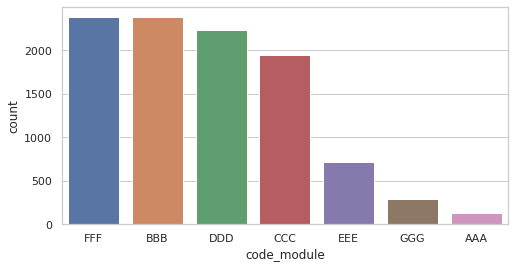

In [79]:
unreg = studentRegistration.query("date_unregistration != 'NaN'").code_module

sns.countplot(unreg, order = unreg.value_counts().index)

sns.set(rc={'figure.figsize':(25,4)}, style="whitegrid")

#### Ответ:

Предметы BBB, FFF, DDD являются самыми популярными. По ним же самое большое число оттоков (только в другом порядке FFF, DDD, DDD).

### Задача 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  (15 баллов) 

#### 1. Посчитаем завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен
Для этого сначала рассчитаем кол-во успешных экзаменов по каждому семестру (без учета пересдач экзаменов прошлых семестров):

In [39]:
count_exam_succsess = df.query("assessment_type == 'Exam' and score >=40 and is_banked == 0")\
                    .groupby('code_presentation', as_index = False)\
                    .agg({'id_assessment':'count'})\
                    .rename(columns = {'id_assessment':'exam_success'})
count_exam_succsess

,code_presentation,exam_success
0,2013B,504
1,2013J,878
2,2014B,1149
3,2014J,1861


Затем рассчитаем количество всех попыток сдать экзамен (без учета пересдач экзаменов прошлых семестров):

In [41]:
count_exam_all = df.query("assessment_type == 'Exam' and is_banked == 0")\
                    .groupby('code_presentation', as_index = False)\
                    .agg({'id_assessment':'count'})\
                    .rename(columns = {'id_assessment':'exam_all'})
count_exam_all

,code_presentation,exam_all
0,2013B,602
1,2013J,968
2,2014B,1271
3,2014J,2118


#### Теперь рассчитаем завершаемость по каждому семестру. Минимальная завершаемость по семестру 2013B=0.84:

In [42]:
completeness = count_exam_all.merge(count_exam_succsess)
completeness['completeness'] = (completeness.exam_success / completeness.exam_all).round(2)
completeness.sort_values('completeness').reset_index(drop = True)

,code_presentation,exam_all,exam_success,completeness
0,2013B,602,504,0.84
1,2014J,2118,1861,0.88
2,2014B,1271,1149,0.90
3,2013J,968,878,0.91


#### 2. Теперь выявим семестр с самыми длинными сроками сдачи курсов. Под сдачей курса будем считать сдачу экзамена. 

На всякий случай уберем пересдачи экзаменов прошлых семестров и отрицательные даты сдачи.

Посчитаем две метрики: средние сроки сдачи в днях(date_submitted) и средние сроки, деленные на продолжительность семестра (submitted_by_length).

In [42]:
date_submitted_per_semestr = df.query("assessment_type == 'Exam' and date_submitted >= 0 and is_banked == 0")\
                    .groupby('code_presentation', as_index = False)\
                    .agg({'date_submitted':'mean', 'module_presentation_length':'mean'})\
                    .reset_index(drop = True)

date_submitted_per_semestr['submitted_by_length'] = (date_submitted_per_semestr.date_submitted / date_submitted_per_semestr.module_presentation_length).round(3)

date_submitted_per_semestr.sort_values('submitted_by_length', ascending = False)

,code_presentation,date_submitted,module_presentation_length,submitted_by_length
2,2014B,232.988985,241.000000,0.967
0,2013B,230.179402,240.000000,0.959
1,2013J,239.505165,261.000000,0.918
3,2014J,243.674221,265.860246,0.917


Видим, что самый длинный средний срок сдачи (date_submitted) в семестре 2014J ~ 244 дня. 

Однако вторая метрика (submitted_by_length), учитывающая среднюю продалжительность курса, более показательна.

У этой метрики самое высокое значение в семестре 2014B. Имеено в этом семестре студенты активизируются и сдают экзамены ближе всего к концу семестра.

#### Ответ:
Семестр с самой низкой завершаемостью: 2013B, средняя завершаемость = 0.84. 

Семестр с самыми длинными сроками сдачи:

- Если считать сроки сдачи в абсолютном выражении, то это семестр 2014J. Средний срок сдачи по нему ~ 244 дня.
- Если считать сроки сдачи в относительном выражении (делить на продолжительность семестра), то это семестр 2014B.

### Задача 6. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 
В адаптированной кластеризации можешь выбрать следующие метрики: 
- R - среднее время сдачи одного экзамена, 
- F - завершаемость курсов, 
- M - среднее количество баллов, получаемое за экзамен. 

Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. (23 балла)

#### 1. Рассчитаем R (Recency) - среднее время сдачи одного экзамена

Сначала сделаем проверку, что по экзаменам нет пересдач и отрицательных дат сдач (если они есть то это усложняет расчет). Видим, что таковых нет:

In [57]:
df.query("assessment_type == 'Exam' and (date_submitted < 0 or is_banked == 1)")

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,module_presentation_length,date_registration,date_unregistration,code_course


Теперь рассчитаем значение метрики по каждому студенту.

Для этого посчитаем средний срок сдачи экзаменов по каждому студенту и среднюю продолжительность курсов, выбранных каждым студентом. 

Поделим первое на второе - эта метрика лучше всего показывает, были ли студентом превышены сроки сдачи:

- если метрика > 1, то сроки сдачи превышены
- если метрика <= 1, то сроки сдачи не превышены

In [45]:
date_submitted_per_student = df.query("assessment_type == 'Exam' and date_submitted >= 0 and is_banked == 0")\
                    .groupby('id_student', as_index = False)\
                    .agg({'date_submitted':'mean', 'module_presentation_length':'mean'})\
                    .sort_values('date_submitted', ascending = False)\
                    .reset_index(drop = True)

date_submitted_per_student['submitted_by_length'] = (date_submitted_per_student.date_submitted / date_submitted_per_student.module_presentation_length).round(2)

date_submitted_per_student.sort_values('submitted_by_length', ascending = False)

,id_student,date_submitted,module_presentation_length,submitted_by_length
2,555008,266.0,241.0,1.10
0,555498,285.0,269.0,1.06
1,2341830,279.0,262.0,1.06
13,391924,251.0,241.0,1.04
49,81351,248.0,240.0,1.03
...,...,...,...,...
1145,642902,243.0,269.0,0.90
1590,480115,243.0,269.0,0.90
1143,695653,243.0,269.0,0.90
1139,679039,243.0,269.0,0.90


В качестве метрики R возьмем столбец submitted_by_length:

In [46]:
R = date_submitted_per_student[['id_student', 'submitted_by_length']].rename(columns={'submitted_by_length':'R_submitted_by_length'})

R

,id_student,R_submitted_by_length
0,555498,1.06
1,2341830,1.06
2,555008,1.10
3,352637,0.96
4,695916,0.98
...,...,...
4628,546953,0.95
4629,86047,0.95
4630,2348111,0.95
4631,546830,0.95


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


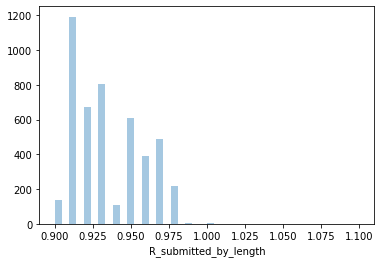

In [98]:
sns.distplot(R.R_submitted_by_length, kde = False)

#### 2. Рассчитаем F (Frequency) - завершаемость курсов

Сначала посчитаем, сколько у каждого студента успешно сданных экзаменов:

In [47]:
count_exam_succsess_per_students = df.query("assessment_type == 'Exam' and score >=40")\
                    .groupby('id_student', as_index = False)\
                    .agg({'id_assessment':'count'})\
                    .rename(columns = {'id_assessment':'exam_success'})\
                    .sort_values('exam_success', ascending = False)

count_exam_succsess_per_students

,id_student,exam_success
2048,592093,2
755,445917,2
1303,543788,2
1881,582879,2
769,447644,2
...,...,...
1398,551814,1
1399,552003,1
1400,552114,1
1401,552166,1


Затем посчитаем, сколько раз каждый студент сдавал экзамены:

In [48]:
count_exam_per_students = df.query("assessment_type == 'Exam'")\
                    .groupby('id_student', as_index = False)\
                    .agg({'id_assessment':'count'})\
                    .rename(columns = {'id_assessment':'exam'})\
                    .sort_values('exam', ascending = False)

count_exam_per_students

,id_student,exam
2316,588482,2
1216,507344,2
1225,509102,2
3465,645792,2
1251,512259,2
...,...,...
1580,547448,1
1581,547612,1
1582,547737,1
1583,547784,1


Теперь объединим эти две таблицы и добавим новый столбец - завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен:

In [49]:
full_count_exams = count_exam_per_students.merge(count_exam_succsess_per_students, how = 'left').fillna(0)

full_count_exams['complitness'] = (full_count_exams.exam_success / full_count_exams.exam)

full_count_exams

,id_student,exam,exam_success,complitness
0,588482,2,2.0,1.0
1,507344,2,2.0,1.0
2,509102,2,2.0,1.0
3,645792,2,2.0,1.0
4,512259,2,2.0,1.0
...,...,...,...,...
4628,547448,1,1.0,1.0
4629,547612,1,1.0,1.0
4630,547737,1,1.0,1.0
4631,547784,1,0.0,0.0


Для дальнейшего анализа нужны только два столбца, выделим их в отдельную таблицу F (завершаемость курсов):

In [50]:
F = full_count_exams[['id_student', 'complitness']].rename(columns={'complitness':'F_complitness'})

F

,id_student,F_complitness
0,588482,1.0
1,507344,1.0
2,509102,1.0
3,645792,1.0
4,512259,1.0
...,...,...
4628,547448,1.0
4629,547612,1.0
4630,547737,1.0
4631,547784,0.0


Видим, что у завершаемости только три значения 0, 0.5, 1. Причем 1 у 88% студентов.

In [51]:
F.F_complitness.value_counts(normalize = True).round(2)

1.0    0.88
0.0    0.12
0.5    0.01
Name: F_complitness, dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


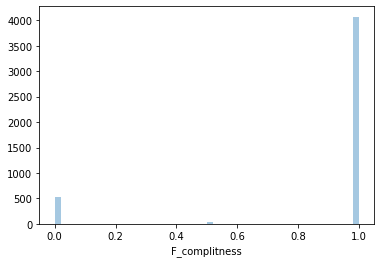

In [104]:
sns.distplot(F.F_complitness, kde = False)

#### 3. Рассчитаем M (Monetary) - среднее количество баллов, получаемое за экзамен

In [52]:
M = df.query("assessment_type == 'Exam'")\
                    .groupby('id_student', as_index = False)\
                    .agg({'score':'mean'})\
                    .sort_values('score', ascending = False)\
                    .rename(columns={'score':'M_score'})\
                    .reset_index(drop = True)
M

,id_student,M_score
0,652902,100.0
1,631473,100.0
2,588274,100.0
3,627401,100.0
4,2131908,100.0
...,...,...
4628,338034,7.0
4629,2588543,4.0
4630,556660,0.0
4631,131152,0.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


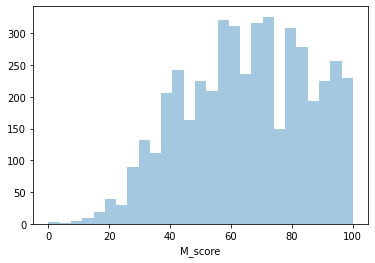

In [106]:
sns.distplot(M.M_score, kde = False)

#### Объединим данные по R, F, M в одну таблицу:

In [53]:
RFM = R.merge(F).merge(M)

RFM

,id_student,R_submitted_by_length,F_complitness,M_score
0,555498,1.06,1.0,58.0
1,2341830,1.06,1.0,49.0
2,555008,1.10,1.0,56.0
3,352637,0.96,1.0,96.0
4,695916,0.98,1.0,67.0
...,...,...,...,...
4628,546953,0.95,1.0,56.0
4629,86047,0.95,1.0,42.0
4630,2348111,0.95,1.0,62.0
4631,546830,0.95,0.0,33.0


### Прежде, чем переходить к сегментации, вспомним:

#### В таблице RFM выделены только те студенты, которые сдавали экзамены.

#### Кроме них еще есть следующие группы студентов:

- студенты, которые зарегистрировались, но впоследствии отменили регистрацию.
- студенты, которые зарегистрировались, не отменяли регистрацию, начали учиться (сдавали промежуточные тесты), но не сдавали экзамен.
- студенты, которые зарегистрировались, но потом не делали никаких действий.

#### Важное замечание:
Надо понимать, что у некоторых студентов есть несколько регистраций на курс (максимум 5). И прохождение по этим курсам может быть разным: по какому-то может быть отмена регистрации, по какому-то успешное прохождение и т.д.
И непонятно, в какую группу относить этих студентов.
В моей работе это делается по алгоритму:
- если студент сдавал хоть один экзамен, то он относится в группу тех, кто сдавал экзамены.
- если студент не сдавал ни одного экзамена, то проверяется, делал ли он отмену регистрации. Если да, то он относится в группу тех, что отменил регистрацию.
- если студент не сдавал ни одного экзамена и не отменял регистрацию, и имеет хотя бы один пройденный тест по какому-либо курсу, то он попадает в группу учившихся, но не дошедших до экзамена.
- если ничего из предыдущего, то он попадает в группу тех, кто только зарегистрировался и не совершал никаких действий.

Думаю, что систему раздения на группы можно осуществить и несколько иным образом, но я считаю целесообразным сделать именно так.

Итак, для того, чтобы выделить вышеперечисленные группы сначала выделим тех студентов, которые сдавали экзамен. Это те студенты, которые вошли в таблицу RFM, их количество = 4633:

In [10]:
students_exam = df.query("assessment_type == 'Exam'").id_student.drop_duplicates().reset_index()

students_exam

,index,id_student
0,46189,29764
1,46198,29820
2,46205,40604
3,46214,42638
4,46226,46605
...,...,...
4628,95941,653319
4629,95965,650232
4630,95976,485421
4631,95980,508615


Теперь посчитаем количество тех, кто отменил регистрацию, их количество = 8704:

In [11]:
students_unregistration = df.query("id_student not in @students_exam.id_student\
                                    and date_unregistration !='NaN'")\
                            .id_student.drop_duplicates()\
                            .reset_index()
students_unregistration

,index,id_student
0,70,65002
1,101,94961
2,132,106247
3,188,129955
4,201,135400
...,...,...
8699,180655,1917808
8700,180656,2239862
8701,180657,2282141
8702,180658,2338614


Затем посчитаем тех, которые зарегистрировались, не отменяли регистрацию, начали учиться (сдавали промежуточные тесты), но не сдавали экзамен. Их количество 14284:

In [12]:
students_nounreg_noexam = df.query("id_student not in @students_exam.id_student\
                                    and id_student not in @students_unregistration.id_student\
                                    and score != 'NaN'")\
                            .id_student.drop_duplicates()\
                            .reset_index()
students_nounreg_noexam

,index,id_student
0,0,11391
1,5,28400
2,10,31604
3,15,32885
4,20,38053
...,...,...
14279,173880,697314
14280,173887,1734156
14281,173895,692171
14282,173901,650630


И наконец, посчитаем количество студентов, которые зарегистрировались, не отменяли регистрацию, не сдавали экзамены, не получали оценки - то есть фактически никаких действий кроме регистрации. Их количество 1164:

In [161]:
students_only_registration = df.query("id_student not in @students_exam.id_student\
                                    and id_student not in @students_unregistration.id_student\
                                    and id_student not in @students_nounreg_noexam.id_student")\
                                .id_student.drop_duplicates()\
                                .reset_index()
students_only_registration

,index,id_student
0,12766,554393
1,106651,174436
2,162760,610738
3,173914,281589
4,173917,346843
...,...,...
1159,180651,697456
1160,180652,698019
1161,180654,1890660
1162,180659,2475886


Сделаем проверку того, что сумма всех четырех групп равна общему количеству студентов, проходивших регистрацию:

In [169]:
students_exam.id_student.count() +\
students_unregistration.id_student.count() +\
students_nounreg_noexam.id_student.count() +\
students_only_registration.id_student.count()

28785

In [95]:
studentRegistration.id_student.nunique()

28785

Проверка пройдена.

### Приступим к кластеризации

#### 1. Студенты, которые зарегистрировались, но отменили регистрацию или не предпринимали никаких действий.

Считаю, что, с точки зрения кластеризации, студентов, которые только зарегистрировались и не предпринимали больше никаких действий, можно объединить с группой тех, кто зарегистрировался и впоследствии отменил регистрацию.
Объединим эти группы в одну. 

Для кластеризации присвоим им оценку 1 по всем трем метрикам:

In [178]:
students_unreg = students_unregistration.merge(students_only_registration, how='outer')

students_unreg = students_unreg.assign(R=1, F=1, M=1)

students_unreg = students_unreg[['id_student', 'R', 'F', 'M']]

students_unreg

,id_student,R,F,M
0,65002,1,1,1
1,94961,1,1,1
2,106247,1,1,1
3,129955,1,1,1
4,135400,1,1,1
...,...,...,...,...
9863,697456,1,1,1
9864,698019,1,1,1
9865,1890660,1,1,1
9866,2475886,1,1,1


#### 2. Cтуденты, которые зарегистрировались, не отменяли регистрацию, начали учиться (сдавали промежуточные тесты), но не сдавали экзамен.

Этим студентам присвоим оценку 2 по всем трем метрикам:

In [181]:
students_nounreg_noexam = students_nounreg_noexam.assign(R=2, F=2, M=2)

students_nounreg_noexam = students_nounreg_noexam[['id_student', 'R', 'F', 'M']]

students_nounreg_noexam

,id_student,R,F,M
0,11391,2,2,2
1,28400,2,2,2
2,31604,2,2,2
3,32885,2,2,2
4,38053,2,2,2
...,...,...,...,...
14279,697314,2,2,2
14280,1734156,2,2,2
14281,692171,2,2,2
14282,650630,2,2,2


#### 3. Студенты, которые сдавали экзамены

Данные по этим студентам были собраны ранее в таблицу RFM:

In [54]:
RFM

,id_student,R_submitted_by_length,F_complitness,M_score
0,555498,1.06,1.0,58.0
1,2341830,1.06,1.0,49.0
2,555008,1.10,1.0,56.0
3,352637,0.96,1.0,96.0
4,695916,0.98,1.0,67.0
...,...,...,...,...
4628,546953,0.95,1.0,56.0
4629,86047,0.95,1.0,42.0
4630,2348111,0.95,1.0,62.0
4631,546830,0.95,0.0,33.0


<b> В статье с описанием подхода к RFM-сегментированию, которая приложена к данному заданию, предлагается проставить оценки R, F, M согласно распредению метрик по квантилям.
    
Однако в других статьях по RFM-сегментированию сказано, что подходы к оцениванию метрик R, F, M могут быть и иными, гибкими и согласующимися со спецификой бизнеса. Шкала оценок также не обязательно может быть пятибальной.<b/> 

<b> Я выбираю 5-ти бальную шкалу. Причем оценки 1 и 2 уже присвоены тем студентам, которые не дошли до сдачи экзаменов.
Значит метрики тех студентов, которые сдавали экзамены, могут быть оценены от 3 до 5.<b/>

#### Метрика R_submitted_by_length 

Отражает среднее время сдачи одного экзамена, деленнное на среднюю продолжительность семестра.

Показывает, были ли студентом превышены сроки сдачи:

- если метрика > 1, то сроки сдачи превышены
- если метрика <= 1, то сроки сдачи не превышены

Основная группа студентов соблюдает сроки сдачи, что видно на графике. Причем основная группа студентов сгруппировалась между 0.9 и 1, то есть в конце семестра. 

На мой взгляд, целесообразно применить бинарную шкалу оценки: 

- если сроки сдачи непревышены, то оценка 5
- если сроки сдачи превышены, то оценка 3

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


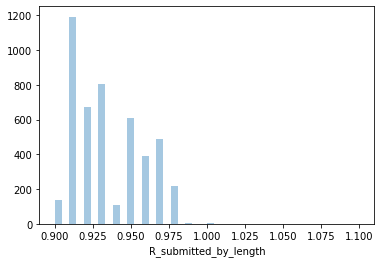

In [186]:
sns.distplot(R.R_submitted_by_length, kde = False)

In [56]:
cut_labels_R = ['5','3']
cut_bins_R = [0, 1, 2]

RFM['R'] = pd.cut(RFM.R_submitted_by_length, bins=cut_bins_R, labels=cut_labels_R)
RFM.head()

,id_student,R_submitted_by_length,F_complitness,M_score,R
0,555498,1.06,1.0,58.0,3
1,2341830,1.06,1.0,49.0,3
2,555008,1.10,1.0,56.0,3
3,352637,0.96,1.0,96.0,5
4,695916,0.98,1.0,67.0,5


#### Метрика F_complitness

Завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен.

Принимает ровно три значения: 0, 0.5, 1.0. Присвоим им оценки 3, 4, 5 соответственно.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


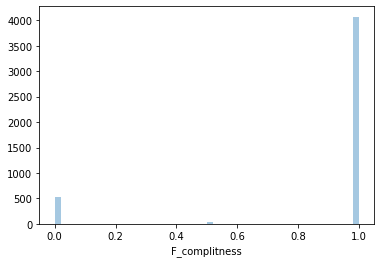

In [191]:
sns.distplot(F.F_complitness, kde = False)

In [236]:
cut_labels_F = ['3','4', '5']
cut_bins_F = [-0.01, 0.49, 0.99, 1.01]

RFM['F'] = pd.cut(RFM.F_complitness, bins=cut_bins_F, labels=cut_labels_F)
RFM

,id_student,R_submitted_by_length,F_complitness,M_score,R,F
0,555498,1.06,1.0,58.0,3,5
1,2341830,1.06,1.0,49.0,3,5
2,555008,1.10,1.0,56.0,3,5
3,352637,0.96,1.0,96.0,5,5
4,695916,0.98,1.0,67.0,5,5
...,...,...,...,...,...,...
4628,546953,0.95,1.0,56.0,5,5
4629,86047,0.95,1.0,42.0,5,5
4630,2348111,0.95,1.0,62.0,5,5
4631,546830,0.95,0.0,33.0,5,3


#### Метрика M_score
Среднее количество баллов, получаемое за экзамен.

- Оценка 40 баллов за экзамен - критерий успешности сдачи экзамена. Поэтому тем, у кого средний балл ниже 40, присвоим оценку 3 (из шкалы от 3 до 5. помним, что оценки 1 и 2 уже заняты студентами, не дошедшими до экзамена).

- Тем, кто получил средний балл выше 80, поставим оценку 5.

- Остальным поставим оценку 4.

Распределение оценок 4 и 5 можно варьировать: например, можно ужесточить критерий оценки 5 - присваивать ее студентом со средним баллом 90, либо можно наоборот смягчить и снизить порог до 70. Порог 80 для 5 - считаю оптимальным.

Можно увеличить количество оценок, но это усложнит интерпретацию RFM-кластеризации. Поэтому остановлюсь на таком количестве оценок.

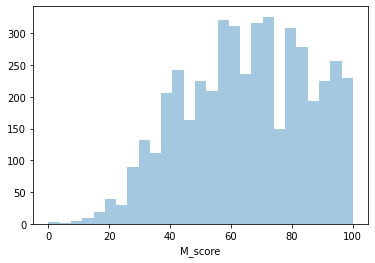

In [203]:
sns.distplot(M.M_score, kde = False)

In [237]:
cut_labels_M = ['3','4', '5']
cut_bins_M = [-0.01, 39.99, 79.99, 100.01]

RFM['M'] = pd.cut(RFM.M_score, bins=cut_bins_M, labels=cut_labels_M)
RFM

,id_student,R_submitted_by_length,F_complitness,M_score,R,F,M
0,555498,1.06,1.0,58.0,3,5,4
1,2341830,1.06,1.0,49.0,3,5,4
2,555008,1.10,1.0,56.0,3,5,4
3,352637,0.96,1.0,96.0,5,5,5
4,695916,0.98,1.0,67.0,5,5,4
...,...,...,...,...,...,...,...
4628,546953,0.95,1.0,56.0,5,5,4
4629,86047,0.95,1.0,42.0,5,5,4
4630,2348111,0.95,1.0,62.0,5,5,4
4631,546830,0.95,0.0,33.0,5,3,3


### Объединим все данные по оценкам студентов в одну общую таблицу

In [238]:
RFM = RFM.merge(students_unreg, how='outer').merge(students_nounreg_noexam, how='outer')
RFM

,id_student,R_submitted_by_length,F_complitness,M_score,R,F,M
0,555498,1.06,1.0,58.0,3,5,4
1,2341830,1.06,1.0,49.0,3,5,4
2,555008,1.10,1.0,56.0,3,5,4
3,352637,0.96,1.0,96.0,5,5,5
4,695916,0.98,1.0,67.0,5,5,4
...,...,...,...,...,...,...,...
28780,697314,NaN,NaN,NaN,2,2,2
28781,1734156,NaN,NaN,NaN,2,2,2
28782,692171,NaN,NaN,NaN,2,2,2
28783,650630,NaN,NaN,NaN,2,2,2


#### Создадим колонку RFM с номерами кластеров студентов

In [284]:
RFM['RFM']=RFM.R.astype(str) + RFM.F.astype(str) + RFM.M.astype(str)

RFM

,id_student,R_submitted_by_length,F_complitness,M_score,R,F,M,RFM
0,555498,1.06,1.0,58.0,3,5,4,354
1,2341830,1.06,1.0,49.0,3,5,4,354
2,555008,1.10,1.0,56.0,3,5,4,354
3,352637,0.96,1.0,96.0,5,5,5,555
4,695916,0.98,1.0,67.0,5,5,4,554
...,...,...,...,...,...,...,...,...
28780,697314,NaN,NaN,NaN,2,2,2,222
28781,1734156,NaN,NaN,NaN,2,2,2,222
28782,692171,NaN,NaN,NaN,2,2,2,222
28783,650630,NaN,NaN,NaN,2,2,2,222


#### Посчитаем количество студентов в каждом кластере

In [285]:
Clasters = RFM.groupby('RFM', as_index=False).agg({'id_student':'count'}).rename(columns={'id_student':'count_students'})

Clasters

,RFM,count_students
0,111,9868
1,222,14284
2,333,2
3,354,4
4,533,534
5,543,7
6,544,21
7,554,2752
8,555,1313


In [286]:
(RFM.RFM.value_counts(normalize=True) * 100).round(3)

222    49.623
111    34.282
554     9.561
555     4.561
533     1.855
544     0.073
543     0.024
354     0.014
333     0.007
Name: RFM, dtype: float64

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


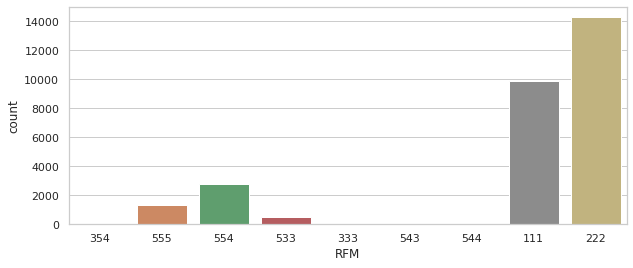

In [287]:
sns.countplot(RFM.RFM)

sns.set(rc={'figure.figsize':(10,4)}, style="whitegrid")

### Описание кластеров

- 111   Количество студентов = 9868. Это 34% студентов. Отменившие регистрацию. Это "потенциал", который надо осваивать. Выявлять причины отмены регистрации, дорабатывать предлагаемые курсы с учетом этого, привлекать данных студентов повторно, повышать лояльность.


- 222   Количество студентов = 14284. Это почти 50% от всех студентов. Начавшие учиться, но не дошедшие до экзаменов. Это "высокопотенциальные". Необходимо выяснить причины, почему студенты не завершили курс. Доработать курсы и экзамены по ним, возможно сдвинуть сроки, поработать над командой поддержки студентов. Также необходимо поработать над повышением лояльности у этой группы студентов. Даже рассмотреть вопрос, чтобы дать им возможность завершить курс, сдав экзамен.
 

Этот кластер вызывает наибольшее количество вопросов. Например, почему студенты сдавали экзамены только по предметам ССС и DDD (это выяснилось при выполнении задания 2). По всем остальным предметам факта сдачи экзаменов не было совсем. Хотя в листе ассессментов экзамены заявлены по всем предметам, правда у некоторых предметов не проставлена дата сдачи, но она не проставлена  и по предмету ССС, что не помешало студентам его сдавать. 

См. ниже визуализацию, какие курсы выбирали студенты данного кластера. Что не так с экзаменами по предметам AAA, BBB, EEE, FFF, GGG? Может экзамены слишком сложные ? Или слишком объемные работы по экзаменам? Тогда нужно серьезно заняться доработкой курсов по этим предметам.

Или может просто отвалился кусок данных, и на самом деле студенты сдавали экзамены по этим предметам ? В таком случае, весь данный анализ абсолютно бессмысленен. И надо искать нормальные данные.


- 333	Количество студентов = 2. Прошедшие курс полностью, но совершенно неуспешно. К счастью, таких мало - они скорее исключение.


- 354	Количество студентов = 4. Успешно окончившие курс, но с превышением сроков. Таких тоже совсем мало, скорее исключение. В основном все успешные студенты пунктуальны.


- 533	Количество студентов = 534. Пунктуальные, но неэффективные. Возможно, подобрали курс сложнее, чем могут потянуть. Чтобы в будущем избежать таких ситуаций: доработать описание курсов, разработать новые курсы по тем же предметам, но только для начинающих. Тогда в будущем такого типа студенты будут правильно выбирать курс, эффективно заканчивать его, и потом возможно будут покупать следующий курс по пройденному предмету, но уже более продвинутый.


- 543	Количество студентов = 7. Пунктуальные, но малоэффективные: часть курсов закончили неуспешно и средний балл низок. Близки к предыдущей группе.


- 544	Количество студентов = 21. Часть курсов окончили неуспешно, но средний балл достаточно высокий и сроки соблюдены. Можно предложить пройти опрос, попытаться выяснить причины неуспешной сдачи. 


- 554	Количество студентов = 2752. Твердые хорошисты, основной костяк успешно окончивших курс. С такими студентами надо продолжать работу, предлагать программу лояльности. Добавлять их в список соискателей на соответствующую работу.


- 555	Количество студентов = 1313. Отличники. С такими студентами надо продолжать работу, предлагать программу лояльности. За отличное окончание - какие-то особенные плюшки, зал славы, возможно некоторым можно сделать предложение о трудоутройстве на соответствующую работу.

#### Визуализация - какие курсы были у студентов, которые не отменили регистрацию, начали проходить курс, но не сдавали экзамен

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


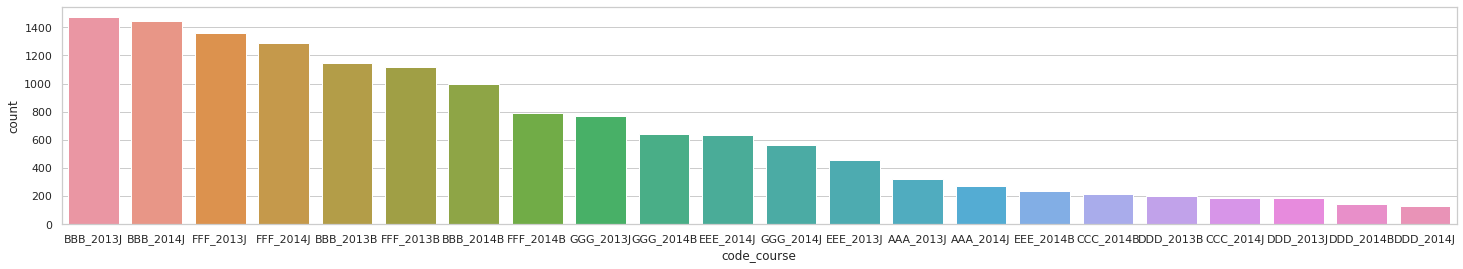

In [29]:
courses_nounreg_noexam = studentRegistration.query("id_student in @students_nounreg_noexam.id_student")
courses_nounreg_noexam['code_course'] = courses_nounreg_noexam.code_module + '_' + courses_nounreg_noexam.code_presentation

sns.countplot(courses_nounreg_noexam.code_course, order = courses_nounreg_noexam.code_course.value_counts().index)
sns.set(rc={'figure.figsize':(25,4)}, style="whitegrid")